In [54]:
# import base stats libraries
import numpy as np
import pandas as pd
import random 
import seaborn as sb
import matplotlib.pyplot as plt

# import yfinance for stock data
import yfinance as yf 

# import torch for model creation and sklearn to scale within reasonable range
import torch
from sklearn.preprocessing import MinMaxScaler

# import progress bar
from tqdm import tqdm

# import decoupling method numpy array split
from collections import deque

#import datetime
#import cv2

In [ ]:
# cuda setup
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

### Trading Environment

In [55]:
class TradingEnv:
    def __init__(self, data, window_size = 30, initial_balance = 10000):
        self.data = data
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.reset()
    
    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.done = False
        return self.getStates()
    
    def getStates(self):
        state = self.data[self.current_step - self.window_size:self.current_step]
        return state.flatten()
    
    def step(self, action):
        price = self.data[self.current_step][3] # close
        prev_net = self.net_worth
        reward = 0

        if action == 1: # Buy
            if self.balance >= price:
                self.balance -= price
                self.shares_held += 1 
        elif action == 2: # sell
            if self.shares_held > 0:
                self.balance += price 
                self.shares_held -= 1
                reward = 1
    
        self.current_step += 1
        if self.current_step >= len(self.data):
            self.done = True
        self.net_worth = self.balance + self.shares_held * price
        reward = self.net_worth - prev_net

        return self.getStates(), reward, self.done

### Network architecture

In [56]:
N_features = 5 # OHLCV
window_size = 30 # 30-day trading window
N_states = N_features * window_size 

class TradingNet(torch.nn.Module):
    def __init__(self):
        super(TradingNet, self).__init__()
        self.fc1 = torch.nn.Linear(N_states,8192)
        self.fc2 = torch.nn.Linear(8192,1024)
        self.fc3 = torch.nn.Linear(1024,3)
        self.activ = torch.nn.LeakyReLU()
    
    def forward(self, x):
        x =self.activ(self.fc1(x))
        x = self.activ(self.fc2(x))
        return self.fc3(x)

### Replay Class

In [57]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)



### Parameters/Settings

In [ ]:
'''Initial model settings will be here '''
# model parameter settings
episodes = 50
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.99
batch_size = 32
buffer_capacity = 10000
model_path = "trading_net_nvda.pth"


### Get data

In [59]:
def stock_data(ticker='NVDA', start="2020-01-01", end="2023-12-31"):
    #load stock data while also cleaning columns of interest
    data = yf.download(ticker, start=start, end=end)[["Open","High","Low","Close","Volume"]].fillna(method='ffill')
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data

### Training

[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_119413/637916187.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = yf.download(ticker, start=start, end=end)[["Open","High","Low","Close","Volume"]].fillna(method='ffill')
Training Episodes:   2%|▏         | 1/50 [00:56<46:14, 56.63s/it]

Episode1/50, Total Reward: 7.423276139474183, Epsilon: 0.9900


Training Episodes:   4%|▍         | 2/50 [01:52<44:44, 55.92s/it]

Episode2/50, Total Reward: 4.279925167274996, Epsilon: 0.9851


Training Episodes:   6%|▌         | 3/50 [02:47<43:34, 55.62s/it]

Episode3/50, Total Reward: 6.679149905181475, Epsilon: 0.9801


Training Episodes:   8%|▊         | 4/50 [03:39<41:43, 54.42s/it]

Episode4/50, Total Reward: 4.880048692828495, Epsilon: 0.9752


Training Episodes:  10%|█         | 5/50 [04:44<43:41, 58.26s/it]

Episode5/50, Total Reward: 8.28130543241059, Epsilon: 0.9704


Training Episodes:  12%|█▏        | 6/50 [05:48<44:04, 60.10s/it]

Episode6/50, Total Reward: 9.03873001268039, Epsilon: 0.9655


Training Episodes:  14%|█▍        | 7/50 [06:52<43:50, 61.18s/it]

Episode7/50, Total Reward: 5.876209793044836, Epsilon: 0.9607


Training Episodes:  16%|█▌        | 8/50 [07:47<41:28, 59.25s/it]

Episode8/50, Total Reward: 17.779806923679644, Epsilon: 0.9559


Training Episodes:  18%|█▊        | 9/50 [08:45<40:22, 59.08s/it]

Episode9/50, Total Reward: 11.494921814415648, Epsilon: 0.9511


Training Episodes:  20%|██        | 10/50 [09:51<40:49, 61.23s/it]

Episode10/50, Total Reward: 20.049376622304408, Epsilon: 0.9464


Training Episodes:  22%|██▏       | 11/50 [11:01<41:26, 63.75s/it]

Episode11/50, Total Reward: 5.80815534627618, Epsilon: 0.9416


Training Episodes:  24%|██▍       | 12/50 [12:03<40:02, 63.22s/it]

Episode12/50, Total Reward: 15.580211892172883, Epsilon: 0.9369


Training Episodes:  26%|██▌       | 13/50 [13:00<37:48, 61.32s/it]

Episode13/50, Total Reward: 10.018685172437472, Epsilon: 0.9322


Training Episodes:  28%|██▊       | 14/50 [13:59<36:22, 60.64s/it]

Episode14/50, Total Reward: -0.28063896848289005, Epsilon: 0.9276


Training Episodes:  30%|███       | 15/50 [14:55<34:36, 59.33s/it]

Episode15/50, Total Reward: 6.231545971495507, Epsilon: 0.9229


Training Episodes:  32%|███▏      | 16/50 [15:51<33:03, 58.33s/it]

Episode16/50, Total Reward: 2.8620924367824045, Epsilon: 0.9183


Training Episodes:  34%|███▍      | 17/50 [16:45<31:16, 56.85s/it]

Episode17/50, Total Reward: 30.420905942553873, Epsilon: 0.9137


Training Episodes:  36%|███▌      | 18/50 [17:45<30:53, 57.92s/it]

Episode18/50, Total Reward: 7.524739055123064, Epsilon: 0.9092


Training Episodes:  38%|███▊      | 19/50 [18:45<30:18, 58.67s/it]

Episode19/50, Total Reward: 4.99277468227956, Epsilon: 0.9046


Training Episodes:  40%|████      | 20/50 [19:53<30:41, 61.39s/it]

Episode20/50, Total Reward: 11.998994187777498, Epsilon: 0.9001


Training Episodes:  42%|████▏     | 21/50 [20:49<28:55, 59.84s/it]

Episode21/50, Total Reward: 17.5729968784035, Epsilon: 0.8956


Training Episodes:  44%|████▍     | 22/50 [21:51<28:09, 60.35s/it]

Episode22/50, Total Reward: 17.53534211155238, Epsilon: 0.8911


Training Episodes:  46%|████▌     | 23/50 [22:47<26:33, 59.01s/it]

Episode23/50, Total Reward: 5.388259807132272, Epsilon: 0.8867


Training Episodes:  48%|████▊     | 24/50 [23:41<24:59, 57.67s/it]

Episode24/50, Total Reward: 11.128550810388333, Epsilon: 0.8822


Training Episodes:  50%|█████     | 25/50 [24:42<24:22, 58.49s/it]

Episode25/50, Total Reward: 6.064734454112113, Epsilon: 0.8778


Training Episodes:  52%|█████▏    | 26/50 [25:42<23:37, 59.06s/it]

Episode26/50, Total Reward: 2.2406886374137684, Epsilon: 0.8734


Training Episodes:  54%|█████▍    | 27/50 [26:42<22:40, 59.17s/it]

Episode27/50, Total Reward: 18.503969155888626, Epsilon: 0.8691


Training Episodes:  56%|█████▌    | 28/50 [27:43<21:53, 59.69s/it]

Episode28/50, Total Reward: 9.161606524285162, Epsilon: 0.8647


Training Episodes:  58%|█████▊    | 29/50 [28:45<21:09, 60.48s/it]

Episode29/50, Total Reward: 10.214903964193581, Epsilon: 0.8604


Training Episodes:  60%|██████    | 30/50 [29:49<20:34, 61.72s/it]

Episode30/50, Total Reward: 6.594727128860541, Epsilon: 0.8561


Training Episodes:  62%|██████▏   | 31/50 [30:55<19:53, 62.81s/it]

Episode31/50, Total Reward: 26.810080535107772, Epsilon: 0.8518


Training Episodes:  64%|██████▍   | 32/50 [31:57<18:49, 62.73s/it]

Episode32/50, Total Reward: 6.452738717529428, Epsilon: 0.8475


Training Episodes:  66%|██████▌   | 33/50 [33:03<18:03, 63.74s/it]

Episode33/50, Total Reward: 12.51218751856868, Epsilon: 0.8433


Training Episodes:  68%|██████▊   | 34/50 [34:04<16:43, 62.69s/it]

Episode34/50, Total Reward: 15.976536058602505, Epsilon: 0.8391


Training Episodes:  70%|███████   | 35/50 [35:13<16:11, 64.76s/it]

Episode35/50, Total Reward: 1.9207881496513437, Epsilon: 0.8349


Training Episodes:  72%|███████▏  | 36/50 [36:12<14:39, 62.86s/it]

Episode36/50, Total Reward: 1.530354591073774, Epsilon: 0.8307


Training Episodes:  74%|███████▍  | 37/50 [37:11<13:23, 61.81s/it]

Episode37/50, Total Reward: 1.250765522614529, Epsilon: 0.8266


Training Episodes:  76%|███████▌  | 38/50 [38:07<12:01, 60.14s/it]

Episode38/50, Total Reward: 0.6545652779768716, Epsilon: 0.8224


Training Episodes:  78%|███████▊  | 39/50 [39:03<10:45, 58.66s/it]

Episode39/50, Total Reward: 3.554305762570948, Epsilon: 0.8183


Training Episodes:  80%|████████  | 40/50 [40:00<09:41, 58.18s/it]

Episode40/50, Total Reward: 6.870878029143569, Epsilon: 0.8142


Training Episodes:  82%|████████▏ | 41/50 [40:56<08:39, 57.72s/it]

Episode41/50, Total Reward: 7.253592132237827, Epsilon: 0.8102


Training Episodes:  84%|████████▍ | 42/50 [42:07<08:13, 61.71s/it]

Episode42/50, Total Reward: 11.020103644943447, Epsilon: 0.8061


Training Episodes:  86%|████████▌ | 43/50 [43:06<07:05, 60.85s/it]

Episode43/50, Total Reward: 15.83536895310317, Epsilon: 0.8021


Training Episodes:  88%|████████▊ | 44/50 [44:07<06:04, 60.77s/it]

Episode44/50, Total Reward: 11.962289594010144, Epsilon: 0.7981


Training Episodes:  90%|█████████ | 45/50 [45:13<05:12, 62.52s/it]

Episode45/50, Total Reward: 11.161199723565005, Epsilon: 0.7941


Training Episodes:  92%|█████████▏| 46/50 [46:16<04:10, 62.69s/it]

Episode46/50, Total Reward: 16.086779304565425, Epsilon: 0.7901


Training Episodes:  94%|█████████▍| 47/50 [47:17<03:06, 62.12s/it]

Episode47/50, Total Reward: 8.373084081278648, Epsilon: 0.7862


Training Episodes:  96%|█████████▌| 48/50 [48:12<01:59, 59.98s/it]

Episode48/50, Total Reward: 10.620537776776473, Epsilon: 0.7822


Training Episodes:  98%|█████████▊| 49/50 [49:11<00:59, 59.75s/it]

Episode49/50, Total Reward: 7.949498876369034, Epsilon: 0.7783


Training Episodes: 100%|██████████| 50/50 [50:08<00:00, 60.17s/it]

Episode50/50, Total Reward: 4.531557330969008, Epsilon: 0.7744
Model saved to trading_net_nvda.pth


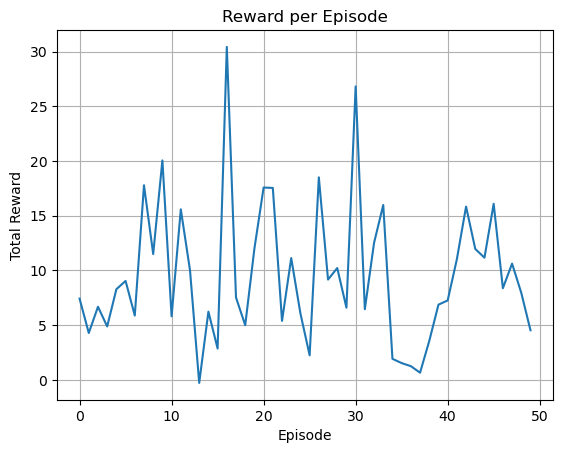

In [ ]:
def train():
    data = stock_data()
    env = TradingEnv(data,30)#30 is for days
    action_size = 3 # buy,sell, hold
    model = TradingNet() # neural network

    #network setup
    target_model = TradingNet().cuda()
    target_model.load_state_dict(model.state_dict())

    net = TradingNet()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
    criterion = torch.nn.MSELoss()
    replay_buffer = ReplayBuffer(buffer_capacity)

    global epsilon # access epsilon variable from settings
    rewards_history = []

    # Training Loop
    for episode in tqdm(range(episodes), desc="Training Episodes"):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            if np.random.rand() <= epsilon:
                action = random.randrange(action_size)
            else:
                with torch.no_grad():
                    action = torch.argmax(model(torch.FloatTensor(state))).item()
            
            next_state, reward, done = env.step(action)
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Replay
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states = torch.FloatTensor(states)
                next_states = torch.FloatTensor(next_states)
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                dones = torch.FloatTensor(dones)

                # values for model states
                q_values = model(states)
                next_q_values = target_model(next_states)

                q_target = q_values.detach().clone()
                q_target[i, actions[i]] = rewards[i] + gamma * torch.max(next_q_values[1]) * (1 - dones[i])

                loss = criterion(q_values, q_target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
            epsilon = max(epsilon_min, epsilon * epsilon_decay)
        target_model.load_state_dict(model.state_dict())
        rewards_history.append(total_reward)
        print(f"Episode{episode+1}/{episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")
    
    # save model
    torch.save(model.state_dict(),model_path)
    print("Model saved to", model_path)

    # display progress
    plt.plot(rewards_history)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Reward per Episode")
    plt.grid()
    plt.show()


# start program
if __name__ == "__main__":
    train()

